As the storm location data we have is subjective, I will attempt to use tobac as a tool to trace the motion of the mesocyclone over time. In this file I will be trying to get the data into the proper format so it can be analyzed by tobac. I am using the "Mapping Data to a Cartesian Grid" Py-ART tutorial. -- Julia Buhrman 01/17/2024

In [16]:
# import necessary stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import coords
import xarray as xr
import pyart
from datetime import timedelta
from radarcalc import *
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy
import metpy.plots
from metpy.units import units
import cartopy.crs as ccrs
import cartopy
import gc
import pyart.core

In [17]:
# import needed modules
import matplotlib.pyplot as plt
import numpy as np
import pyart

In [19]:
# bring in the data, in this case it's from Morton

# gps data for first ka
ka1gps = pd.read_csv('/Users/juliabman/Desktop/research2024/GPS_Ka1_20220523.txt')
# scan data for first ka
ka1scan = pd.read_csv('/Users/juliabman/Desktop/research2024/20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])

# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska1 = sorted(glob.glob('/Users/juliabman/Desktop/research2024/product_raw_ka1/*.nc'))

# sanity checks to make sure they're loading in:
print(vad_fileska1)
#print(ka1gps)

['/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka12205232.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523205632.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523205701.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523205730.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523205759.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523205828.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523205857.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523205926.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523205955.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523221718.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523222551.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523222620.nc', '/Users/juliabman/Desktop/research2024/product_raw_ka1/Ka1220523222649.nc', '/Users/juliabma

In [20]:
ka1gps

,ddmmyy,hhmmss[UTC],Longitude,Latitude,Velocity[knots],Bearing[degrees]
0,230522,183124,-102.031783,33.588547,0.00,140.92
1,230522,183125,-102.031783,33.588547,0.00,140.92
2,230522,183126,-102.031783,33.588547,0.00,140.92
3,230522,183127,-102.031783,33.588547,0.00,140.92
4,230522,183128,-102.031783,33.588547,0.00,140.92
...,...,...,...,...,...,...
31901,240522,32353,-102.032235,33.589625,0.22,52.29
31902,240522,32354,-102.032227,33.589630,0.50,52.29
31903,240522,32355,-102.032210,33.589645,1.53,35.15
31904,240522,32356,-102.032200,33.589662,3.10,17.84


In [21]:
xr.open_dataset(vad_fileska1[0])

<xarray.Dataset>
Dimensions:                    (time: 2039, range: 555, sweep: 2)
Coordinates:
  * time                       (time) datetime64[ns] 2022-05-23T20:57:34 ... ...
  * range                      (range) float32 0.0 18.0 ... 9.954e+03 9.972e+03
    azimuth                    (time) float32 ...
    elevation                  (time) float32 ...
Dimensions without coordinates: sweep
Data variables: (12/30)
    total_power                (time, range) float32 ...
    reflectivity               (time, range) float32 ...
    velocity                   (time, range) float32 ...
    spectrum_width             (time, range) float32 ...
    corrected_velocity         (time, range) float32 ...
    normalized_coherent_power  (time, range) float32 ...
    ...                         ...
    time_coverage_end          |S32 ...
    time_reference             |S32 ...
    volume_number              int32 ...
    platform_type              |S32 ...
    instrument_type            |S32 ...
    primary_axis               |S32 ...
Attributes: (12/15)
    Conventions:             CF/Radial instrument_parameters
    version:                 1.3
    title:                   
    institution:             
    references:              
    source:                  
    ...                      ...
    sigmet_task_name:        AF_VAD      
    sigmet_extended_header:  false
    time_ordered:            none
    rays_missing:            7
    field_names:             total_power, reflectivity, velocity, spectrum_wi...
    history:

In [22]:
# read the data that is in ANTENNA COORDINATES? 
# the data right now is not in antenna coordinates

radar = pyart.io.read(vad_fileska1[37])

In [23]:
radar

It seems that radar is already a .Radar file, which stores antenna coordinate radar data

In [24]:
#radar.fields['data'], radar.metadata['data'], radar.scan_type['data'], radar.sweep_start_ray_index['data'], radar.sweep_end_ray_index['data'], radar.azimuth['data'], radar.elevation['data'])

In [25]:
# attempts to get the data into antenna coordinates by manually filling in each area of data
#antennta_coords = pyart.core.Radar(radar.range['data'], radar.latitude['data'], radar.longitude['data'], radar.altitude['data'], radar.sweep_number['data'], radar.sweep_mode['data'], radar.fixed_angle['data'])

In [28]:
# shortcut to making list then appending all indeces
all_sweeps = [pyart.io.read(f) for f in vad_fileska1]
# see bruno medina floor 11 for help on tracking velocity stuff

In [48]:
grid = pyart.map.grid_from_radars(
    all_sweeps,
    grid_shape = (100, 200, 200),
    grid_limits = (
        (
            0.0,
            10000,
        ),
        (-10000.0, 10000.0),
        (-10000, 10000.0),
    ),
)

*The grid spacing (how detailed the grid is) is the grid limits divided by the grid shape (per z, y, x)*

In [49]:
xgrids = grid.to_xarray()
xgrids

<xarray.Dataset>
Dimensions:                    (time: 1, z: 100, y: 200, x: 200)
Coordinates:
  * time                       (time) object 2022-05-23 20:57:34
  * z                          (z) float64 0.0 101.0 202.0 ... 9.899e+03 1e+04
    lat                        (y) float64 43.44 43.44 43.44 ... 43.62 43.62
    lon                        (x) float64 -94.76 -94.75 ... -94.51 -94.51
  * y                          (y) float64 -1e+04 -9.899e+03 ... 9.899e+03 1e+04
  * x                          (x) float64 -1e+04 -9.899e+03 ... 9.899e+03 1e+04
Data variables:
    velocity                   (time, z, y, x) float32 nan nan nan ... nan nan
    total_power                (time, z, y, x) float32 nan nan nan ... nan nan
    corrected_velocity         (time, z, y, x) float32 nan nan nan ... nan nan
    velocity_texture           (time, z, y, x) float64 nan nan nan ... nan nan
    spectrum_width             (time, z, y, x) float32 nan nan nan ... nan nan
    normalized_coherent_power  (time, z, y, x) float32 nan nan nan ... nan nan
    reflectivity               (time, z, y, x) float32 nan nan nan ... nan nan
    ROI                        (time, z, y, x) float32 500.0 500.0 ... 870.3

In [50]:
#xgrids.reflectivity.isel(z=0, time=0).plot.pcolormesh(cmap='pyart_ChaseSpectral', vmin=-10, vmax=80)

In [59]:
# fig = plt.figure(figsize = [8,8])
# display = pyart.graph.GridMapDisplay(grid)
# display.plot_grid("reflectivity", level = 0, vmin = -20, vmax = 60)

In [81]:
grid2 = pyart.map.grid_from_radars(
    all_sweeps,
    grid_shape = (50, 100, 100),
    grid_limits = (
        (
            0.0,
            10000,
        ),
        (-10000.0, 10000.0),
        (-10000, 10000.0),
    ),
)

In [60]:
# data for ka 2

ka2gps = pd.read_csv('/Users/juliabman/Desktop/research2024/GPS_Ka2_20220523.txt')
# scan data for first ka
ka2scan = pd.read_csv('/Users/juliabman/Desktop/research2024/20220523_Ka2_scan_log.txt', dtype=str,
                     parse_dates=[0])

# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska2 = sorted(glob.glob('/Users/juliabman/Desktop/research2024/product_raw_ka2/*.nc'))

# sanity checks to make sure they're loading in:
#print(vad_fileska2)
#print(ka2gps)

In [61]:
radar2 = pyart.io.read(vad_fileska2[37])

In [78]:
grid.x["data"]

array([-10000.        ,  -9899.49748744,  -9798.99497487,  -9698.49246231,
        -9597.98994975,  -9497.48743719,  -9396.98492462,  -9296.48241206,
        -9195.9798995 ,  -9095.47738693,  -8994.97487437,  -8894.47236181,
        -8793.96984925,  -8693.46733668,  -8592.96482412,  -8492.46231156,
        -8391.95979899,  -8291.45728643,  -8190.95477387,  -8090.45226131,
        -7989.94974874,  -7889.44723618,  -7788.94472362,  -7688.44221106,
        -7587.93969849,  -7487.43718593,  -7386.93467337,  -7286.4321608 ,
        -7185.92964824,  -7085.42713568,  -6984.92462312,  -6884.42211055,
        -6783.91959799,  -6683.41708543,  -6582.91457286,  -6482.4120603 ,
        -6381.90954774,  -6281.40703518,  -6180.90452261,  -6080.40201005,
        -5979.89949749,  -5879.39698492,  -5778.89447236,  -5678.3919598 ,
        -5577.88944724,  -5477.38693467,  -5376.88442211,  -5276.38190955,
        -5175.87939698,  -5075.37688442,  -4974.87437186,  -4874.3718593 ,
        -4773.86934673,  

/Users/juliabman/miniforge3/envs/Research/lib/python3.8/site-packages/pyart/graph/gridmapdisplay.py:243: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Mercator.
  warnings.warn(
/Users/juliabman/miniforge3/envs/Research/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


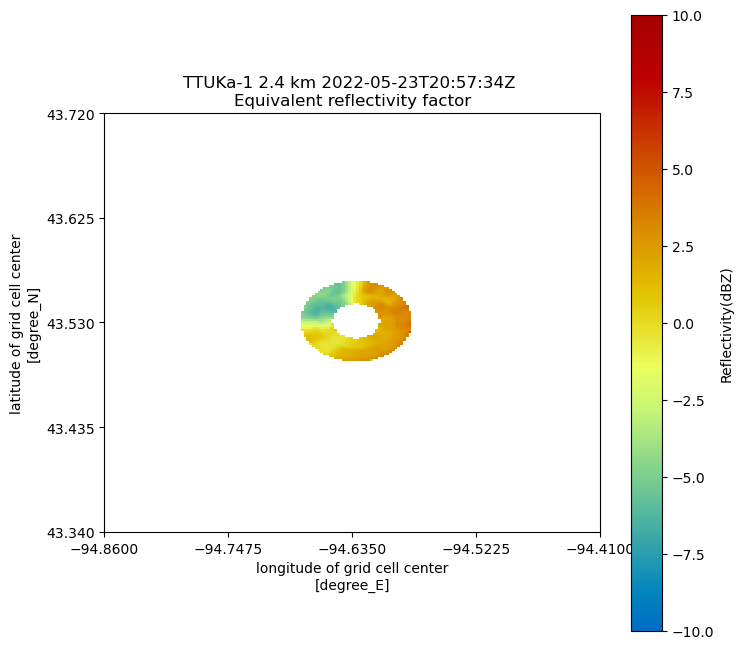

In [82]:
fig = plt.figure(figsize = [8,8])
display = pyart.graph.GridMapDisplay(grid2)
display.plot_grid("reflectivity", level = 12, vmin = -10, vmax = 10)

(-10.0, 10.0)

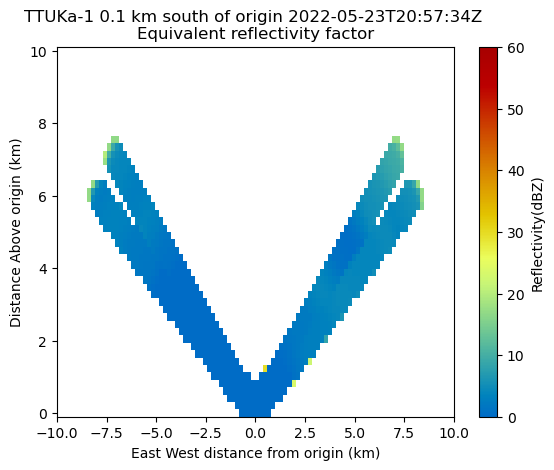

In [74]:
display.plot_latitude_slice("reflectivity", lat = 43.53, vmin = 0, vmax = 60)
plt.xlim([-10,10])

It appears that the scan is smaller than the one provided on the website's examples? It is also missing data in the center of both graphs...

I may have to grab the data from the 88d by manually finding the storm and pulling it from the website??

In [75]:
display = pyart.graph.RadarMapDisplay(radar)

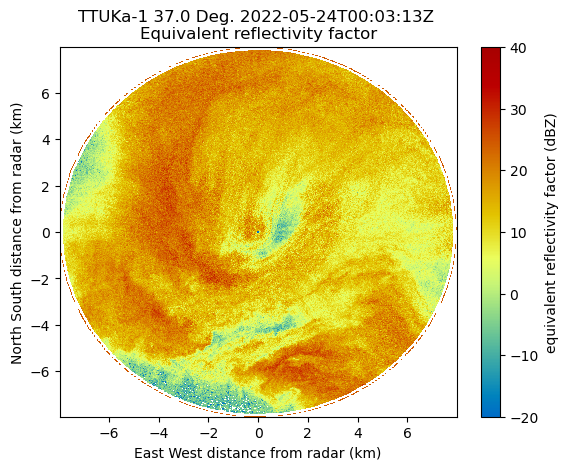

In [76]:
display.plot_ppi("reflectivity", vmin = -20, vmax = 40)
plt.show()

In [ ]:
grid = pyart.map.grid_from_radars(
    radar,
    grid_shape = (41, 201, 201),
    grid_limits = (
        (
            0.0,
            20000,
        ),
        (-100000.0, 100000.0),
        (-100000, 100000.0),
    ),
)

Use tobac to find storm motion instead of just where the velocity couplet path is. Tobac can hypothetically determine storm motion more easily than just the path of one mesocyclone.